# EY Open Science AI & Data Challenge 2025 : Cooling Urban Heat Islands
# Script Explicatif - Enzo Sebiane -

###  <u> Introduction

Ce script retrace l'ensemble du cheminement suivi pour ce challenge, depuis la génération des données jusqu'à l'entraînement du modèle et la soumission des résultats.

⚠ **Attention** : Il est possible que le notebook complet ne s'exécute pas directement tel quel, car il reprend des éléments issus de plusieurs scripts distincts. Cela explique également pourquoi le jeu de données d'entraînement est parfois rechargé.

Cependant, tout est normalement suffisamment détaillé pour permettre une reproduction fidèle des résultats obtenus.

En cas de problème, n'hésitez pas à me contacter à l'adresse suivante : **enzo.sebiane@orange.fr**.


 ### <u> Librairies Utilisées</u>

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# General utilities
import os
from tqdm import tqdm
import xml.etree.ElementTree as ET

# Data handling
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import jet, RdYlGn

# Geospatial data handling
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio import windows, features, warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds
from rasterio.transform import from_bounds
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering & Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameter Optimization
import optuna

# Planetary Computer & STAC tools
import pystac_client
import planetary_computer
from pystac.extensions.eo import EOExtension as eo
import stackstac
from odc.stac import stac_load


#  <u> Courte Analyse des Données

### Analyse du Training Set

Nous nous intéressons tout d'abord au **jeu de données d'entraînement** afin de mieux comprendre sa structure et ses caractéristiques.

In [3]:
ground_df = pd.read_csv("/home/enzo/PycharmProjects/Recre/Dataset/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


Les données étant déjà nettoyées et normalisées, je n'ai pas eu beaucoup de travail à effectuer en amont.


**Remarque intéressante** : Le nombre de valeurs uniques est relativement faible par rapport à la taille du dataset.


In [3]:
print(ground_df['UHI Index'].describe())
print(f"Nombre de valeurs uniques: {ground_df['UHI Index'].nunique()}")

count    11229.000000
mean         1.000001
std          0.016238
min          0.956122
25%          0.988577
50%          1.000237
75%          1.011176
max          1.046036
Name: UHI Index, dtype: float64
Nombre de valeurs uniques: 595


In [4]:
print(f"Nombre de valeurs nulles: {ground_df['UHI Index'].isnull().sum()}")

Nombre de valeurs nulles: 0


Comme indiqué dans l'énoncé, on observe bien une distribution gaussienne, due à la normalisation `valeur / valeur_moyenne`, centrée autour de 1.


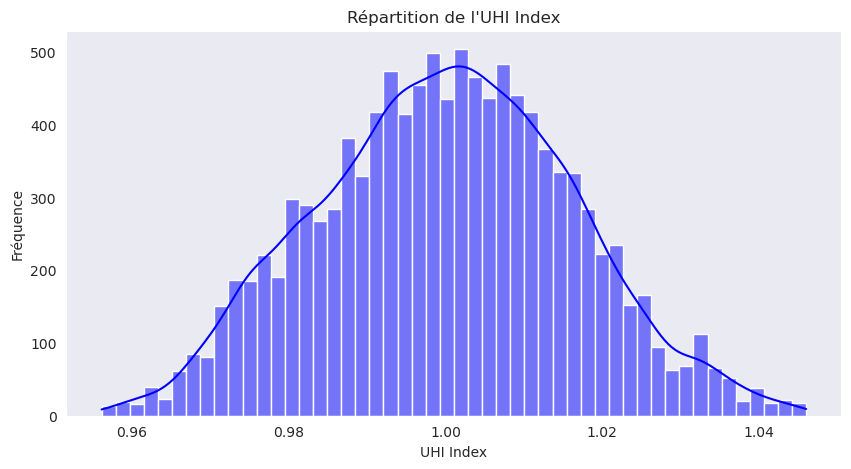

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(ground_df['UHI Index'], bins=50, kde=True, color="blue")
plt.xlabel("UHI Index")
plt.ylabel("Fréquence")
plt.title("Répartition de l'UHI Index")
plt.grid()
plt.show()

### Analyse rapide du Submission Template

Ce qui est intéressant pour la suite de notre étude, c'est principalement la taille du **submission template**.


In [3]:
submission_template = pd.read_csv("Data//Dataset/Submission_template.csv")
print(submission_template.shape)

(1040, 3)


Avec un nombre de lignes de 1040, on peut donc se baser sur une bonne estimation pour nos entraînements. En prenant un test split de 9,5% de notre jeu d'entraînement, cela correspond à environ 1067 lignes.


In [73]:
submission_template.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


#  <u> Génération de nos Données

### Travail important dans cette étude

C'est sûrement le travail le plus important dans cette étude, qui aurait peut-être mérité plus d'attention de ma part.

En résumé, nous allons utiliser comme données principales celles des satellites **Landsat**, avec une génération **multirésolution** pour capturer les liens à différentes échelles. Nous utilisons également les données de **Sentinel** dans une moindre mesure, en prenant des valeurs médianes sur les différentes années, afin d'ajouter de la diversité et de la complexité aux données. Enfin, nous exploitons les données des **bâtiments**, non pas comme une densité, mais comme une information cachée de localisation (en restant dans les règles bien entendu), permettant ainsi de regrouper nos données en clusters, commme si on effectuait un **unsupervised learning** en amont.


## Sentinel

### Données du satellite Sentinel

Tout d'abord, nous nous intéressons aux données du satellite **Sentinel**. Après quelques études, nous constatons que ces données ne varient pas énormément d'un point à un autre de notre jeu de données, notamment en ce qui concerne l'index à prédire (assez peu de valeurs uniques).

Cependant, pour tenir compte de la majeure partie de l'information, nous sélectionnons pour toutes les années disponibles (de 2015 à 2024) la moyenne sur **3 mois d'été**.


### Sélection de la meilleure résolution

Quitte à ne garder qu'un seul set de données, nous choisissons la **meilleure résolution possible**, à savoir **1m par pixel**, dans le but de faire varier les valeurs le plus possible d'une position à une autre.


In [ ]:
# Define the geographic area (Manhattan)
bounds = (-74.01, 40.75, -73.86, 40.88)

# Create output directory
output_dir = "GeoTIFF_Medians_Res_1"
os.makedirs(output_dir, exist_ok=True)

# STAC client
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Resolution and scale
resolution = 1  # 1m per pixel
scale = resolution / 111320.0  # Convert to degrees (EPSG:4326)

# Process data from 2015 to 2024 (May-September)
for year in range(2015, 2025):
    time_window = f"{year}-05-01/{year}-09-30"

    # Search Sentinel-2 images with <30% cloud cover
    search = stac.search(bbox=bounds, datetime=time_window, collections=["sentinel-2-l2a"], query={"eo:cloud_cover": {"lt": 30}})
    items = list(search.get_items())

    # Load data
    data = stac_load(items, bands=["B01", "B04", "B08", "B11"], crs="EPSG:4326", resolution=scale,
                     chunks={"x": 2048, "y": 2048}, dtype="uint16", patch_url=planetary_computer.sign, bbox=bounds)

    # Compute median composite
    median = data.median(dim="time").compute()

    # Save as GeoTIFF
    filename = os.path.join(output_dir, f"S2_median_{year}_may_sep.tiff")
    transform = rasterio.transform.from_bounds(*bounds, median.dims["longitude"], median.dims["latitude"])
    median.rio.write_crs("epsg:4326", inplace=True)
    median.rio.write_transform(transform=transform, inplace=True)

    with rasterio.open(filename, 'w', driver='GTiff', width=median.dims["longitude"], height=median.dims["latitude"],
                       crs='epsg:4326', transform=transform, count=4, compress='lzw', dtype='float64') as dst:
        dst.write(median.B01, 1)  # Blue
        dst.write(median.B04, 2)  # Red
        dst.write(median.B08, 3)  # NIR
        dst.write(median.B11, 4)  # SWIR

    print(f"Generated: {filename}")


### Sélection des bandes spectrales

Nous ne conservons que les bandes **B01, B04, B06 et B08**, car elles contiennent les informations du **NDVI** et correspondent à celles utilisées dans le notebook d'exemple.


In [ ]:
# Process band values from a GeoTIFF image
def map_satellite_data(tiff_path, csv_path):

    # Load GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Load CSV with coordinates
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Convert coordinates to GeoTIFF CRS
    proj_wgs84 = Proj(init='epsg:4326')
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values, B04_values, B06_values, B08_values = [], [], [], []

    # Extract band values at each location
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        B01_values.append(data.sel(x=lon, y=lat, band=1, method="nearest").values)
        B04_values.append(data.sel(x=lon, y=lat, band=2, method="nearest").values)
        B06_values.append(data.sel(x=lon, y=lat, band=3, method="nearest").values)
        B08_values.append(data.sel(x=lon, y=lat, band=4, method="nearest").values)

    # Create DataFrame with extracted values
    df = pd.DataFrame({'B01': B01_values, 'B04': B04_values, 'B06': B06_values, 'B08': B08_values})

    return df

# Create output directory
output_dir = "GeoTIFF_Medians"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

# CSV file with coordinates
csv_file = "/home/enzo/PycharmProjects/Recre/Dataset/Submission_template.csv"

# Store data per year
final_data = {}

# Process years 2015-2024
for year in range(2015, 2025):
    tiff_path = os.path.join(output_dir, f"S2_median_{year}_may_sep.tiff")

    if os.path.exists(tiff_path):
        print(f"Processing {tiff_path}")
        df_year = map_satellite_data(tiff_path, csv_file)

        # Store extracted values
        final_data[f'B01_{year}'] = df_year['B01']
        final_data[f'B04_{year}'] = df_year['B04']
        final_data[f'B06_{year}'] = df_year['B06']
        final_data[f'B08_{year}'] = df_year['B08']

# Convert to DataFrame
final_dataset = pd.DataFrame(final_data)

# Save to CSV
final_dataset_path = os.path.join(output_dir, 'final_dataset_sub.csv')
final_dataset.to_csv(final_dataset_path, index=False)

print(f"Final dataset saved: {final_dataset_path}")


### > Mapping avec le Submission Template

Une fois le dataset généré, il est nécessaire de le **mapper sur le submission template** afin de préparer la soumission.


In [4]:
data_geotiff_median = pd.read_csv("/home/enzo/PycharmProjects/Recre/GeoTIFF_Medians/final_dataset.csv")

## Landsat

### Analyse des modèles de classification

Après plusieurs tests sur des modèles de classification plus simples (**Random Forest, HistGradientBoosting de Scikit-Learn**), il s'avère que les **données de Landsat** sont les plus pertinentes pour optimiser les performances de prédiction.

Cette observation peut s'expliquer par plusieurs facteurs :
- Une **meilleure précision** des données,
- Une **plus grande plage temporelle** (de **2013 à 2024**),
- Le fait que les **indices bruts** fournis par Landsat retranscrivent mieux l'**UHI index**.

Je n'ai pas pris le temps d'explorer en détail la possibilité de travailler directement sur des indices (NDVI, NDBI, etc.) plutôt que sur des données brutes, ce qui pourrait être une piste d'amélioration.


**Réutilisation du code d'exemple** : Rien de nouveau dans cette cellule : il s'agit simplement d'une reprise du **code d'exemple** fourni.


In [ ]:
# Define bounding box (lat, lon) for NYC
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Search Landsat-8 data (2020)
time_window = "2020-01-01/2020-12-31"
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 10}, "platform": {"in": ["landsat-8"]}},
)
items = list(search.get_items())
print('Scenes found:', len(items))
for item in items:
    print(f" Item {item.id} - Bands: {item.assets}")
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

# Define resolution (degrees per pixel)
resolution = 30  # meters
scale = resolution / 111320.0

# Load bands
data1 = stac_load(
    items, bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", resolution=scale,
    chunks={"x": 2048, "y": 2048}, dtype="uint16",
    patch_url=planetary_computer.sign, bbox=bounds
)
data2 = stac_load(
    items, bands=["lwir11"],
    crs="EPSG:4326", resolution=scale,
    chunks={"x": 2048, "y": 2048}, dtype="uint16",
    patch_url=planetary_computer.sign, bbox=bounds
)

# Apply scale factors
data1 = data1.astype(float) * 0.0000275 - 0.2
data2 = data2.astype(float) * 0.00341802 + 149.0 - 273.15  # Convert to °C

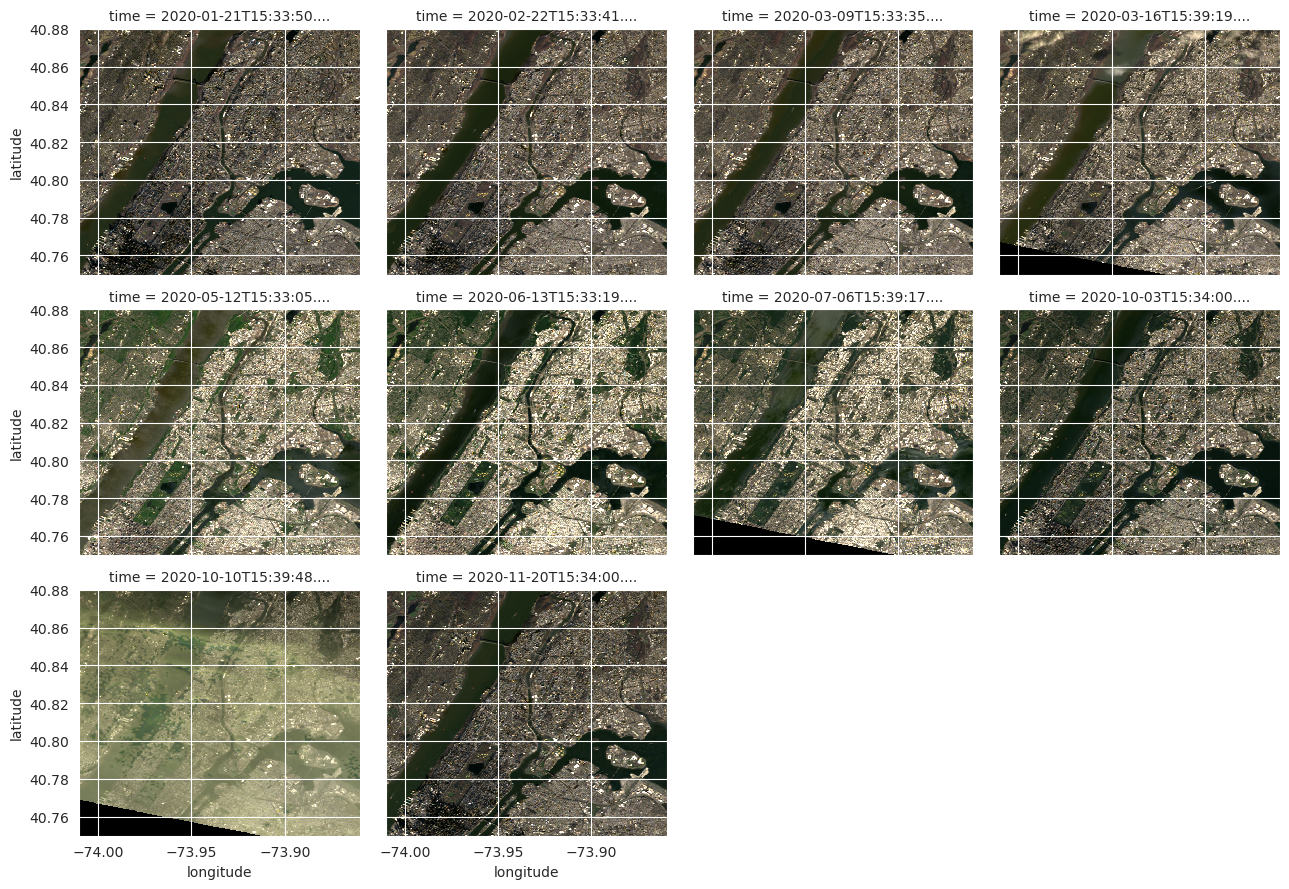

In [5]:

# Plot RGB image
plot_data = data1[["red", "green", "blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()


### Simplification du script de génération des données

Pour des raisons de **lisibilité**, j'ai extrait du script de génération de données à partir de **Landsat** uniquement les **cellules principales** permettant la génération à une **résolution de 10%**.

Le processus est **identique** pour la génération des différentes résolutions.


### Intérêt de la génération à différentes résolutions

L'intérêt d'une génération à **différentes résolutions** est de créer du **contexte**, en lien avec le modèle utilisé (que nous verrons par la suite).

Plus la **résolution est grande** (c'est-à-dire plus on prend de la hauteur), plus les **points proches** sont regroupés sous une **même valeur**, ce qui permet d'introduire des **informations positionnelles** dans le modèle.


In [ ]:
# Load thermal band (Landsat LST)
data2 = stac_load(
    items, bands=["lwir11"],
    crs="EPSG:4326", resolution=scale,
    chunks={"x": 2048, "y": 2048}, dtype="uint16",
    patch_url=planetary_computer.sign, bbox=bounds
)

# Create output directory
output_dir = "Landsat/2020_10_percent"
os.makedirs(output_dir, exist_ok=True)

# Save each time slice as GeoTIFF
for i in range(data2.sizes["time"]):
    data_slice = data2.isel(time=i)
    filename = os.path.join(output_dir, f"Landsat_LST_slice_{i+1}.tiff")

    # Get dimensions and transformation
    height, width = data_slice.dims["latitude"], data_slice.dims["longitude"]
    gt = from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

    data_slice.rio.write_crs("epsg:4326", inplace=True)
    data_slice.rio.write_transform(transform=gt, inplace=True)

    # Save as GeoTIFF
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       crs='epsg:4326', transform=gt, count=1, compress='lzw', dtype='float64') as dst:
        dst.write(data_slice.lwir11, 1)

    print(f"Saved: {filename}")


### Adaptation de la fonction mapping de Sentinel

Il s'agit simplement d'une adaptation de la fonction pour le satellite **Sentinel**, qui permet de **mapper correctement les données** et de **s'affranchir des coordonnées**.


In [ ]:
def map_satellite_data_LST(tiff_path, csv_path):
    # Load GeoTIFF
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Load CSV coordinates
    df = pd.read_csv(csv_path)
    latitudes, longitudes = df['Latitude'].values, df['Longitude'].values

    # Coordinate transformation
    transformer = Transformer.from_proj(Proj(init='epsg:4326'), Proj(tiff_crs))

    # Extract LST values
    lst_values = [
        data.sel(x=lon, y=lat, band=1, method="nearest").values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values")
    ]

    # Create DataFrame with LST values
    return pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes, 'LST': lst_values})


In [ ]:
import pandas as pd
import os

# Paths
output_dir = "Data/Landsat/2020_10_percent"
csv_path = "Data/Dataset/Training_data_uhi_index_2025-02-18.csv"

dataframes = []

# Process each TIFF file
for i in range(1, total_slices + 1):
    filename = os.path.join(output_dir, f"Landsat_LST_slice_{i}.tiff")

    if os.path.exists(filename):
        dataframes.append(map_satellite_data_LST(filename, csv_path))
        print(f"Processed: {filename}")
    else:
        print(f"File not found: {filename}")

# Merge all data and save
final_df = pd.concat(dataframes, axis=1)
final_df.to_csv(os.path.join(output_dir, "data_Landsat_2020_10_percent.csv"), index=False)

final_df.head()


### Génération des données pour différentes résolutions

Nous reproduisons la génération pour les résolutions **1m, 10m, 30m, 50m, 80m**. Bien que le choix des résolutions soit **assez arbitraire**, il permet de **réduire de manière assez constante** le nombre de valeurs uniques dans notre jeu de données, ce qui est l'élément recherché via cette méthode.


### Ajout d'un dataset supplémentaire

En petit plus, nous ajoutons un dernier **dataset** qui correspond à la **moyenne des données** issues des différentes résolutions.


In [6]:


data_landsat_res_1 = pd.read_csv("Data/10cl_Landsat_LWIR11_Temperature_Res/final_dataset_landsat_lwir11_res_1m.csv")
data_landsat_res_80 = pd.read_csv("Data/Landsat_LWIR11_Temperature_Res80/final_dataset_landsat_lwir11_res_80.csv")
data_landsat_res_10 = pd.read_csv("Data/10cl_Landsat_LWIR11_Temperature_Res/final_dataset_landsat_lwir11_res_10m.csv")
data_landsat_res_30 = pd.read_csv("Data/10cl_Landsat_LWIR11_Temperature_Res/final_dataset_landsat_lwir11_res_30m.csv")
data_landsat_res_50 = pd.read_csv("Data/10cl_Landsat_LWIR11_Temperature_Res/final_dataset_landsat_lwir11_res_50m.csv")

# Average
data_Landsat = pd.read_csv("Data/Landsat_final_concat.csv")


### Concatenation des données

Nous procédons à la **concaténation brute et naïve** de toutes nos données générées, **sur les colonnes** évidemment.


In [7]:
final_data = pd.concat([data_landsat_res_1,data_landsat_res_10, data_landsat_res_30,data_landsat_res_50,data_landsat_res_80,data_Landsat,data_geotiff_median], axis=1)
final_data = final_data.loc[:, ~final_data.columns.str.contains("Unnamed")]

print(final_data.shape)
final_data.head()

(11229, 696)


,lwir11_Res1m_slice_1,lwir11_Res1m_slice_2,lwir11_Res1m_slice_3,lwir11_Res1m_slice_4,lwir11_Res1m_slice_5,lwir11_Res1m_slice_6,lwir11_Res1m_slice_7,lwir11_Res1m_slice_8,lwir11_Res1m_slice_9,lwir11_Res1m_slice_10,...,B06_2022,B08_2022,B01_2023,B04_2023,B06_2023,B08_2023,B01_2024,B04_2024,B06_2024,B08_2024
0,2.371428,44.433582,44.443837,38.069229,38.089737,2.265470,43.708962,43.702126,37.378789,37.389043,...,2482.0,2445.0,1892.5,2050.0,2473.0,2440.5,1856.0,2083.0,2630.0,2616.0
1,2.371428,44.433582,44.443837,38.069229,38.089737,2.265470,43.708962,43.702126,37.378789,37.389043,...,2482.0,2445.0,1892.5,2050.0,2473.0,2440.5,1856.0,2083.0,2630.0,2616.0
2,2.265470,43.708962,43.702126,37.378789,37.389043,2.265470,43.708962,43.702126,37.378789,37.389043,...,3479.0,2520.0,1892.5,1917.5,3403.0,2720.5,1856.0,1838.0,3714.0,2639.0
3,2.265470,43.708962,43.702126,37.378789,37.389043,2.265470,43.708962,43.702126,37.378789,37.389043,...,3279.0,2520.0,1892.5,1905.5,3271.0,2720.5,1856.0,1817.0,3594.0,2639.0
4,2.265470,43.708962,43.702126,37.378789,37.389043,2.344084,43.346652,43.350070,36.835324,36.842160,...,3108.0,2727.0,1892.5,1895.0,3106.0,2930.5,1856.0,1752.5,3404.0,2731.5


## Building

### Ajout de la dernière colonne provenant du dataset BuildingFootprint.kml

La dernière colonne de données provient du dataset **BuildingFootprint.kml**. Nous l'utilisons de manière **assez peu standard**, car plutôt que de travailler sur la **densité** ou l'**empreinte** des bâtiments, nous l'utilisons simplement comme une **nouvelle carte**.

Tous les bâtiments sont **étirés pour recouvrir tout Manhattan**, et nous utilisons une fonction qui va **mapper** nos jeux de données dessus, nous permettant ainsi de **s'affranchir des coordonnées**, de la même manière qu'avec les images satellites.


**Remarque** : Cette approche pourrait **très clairement être perfectionnée** avec une étude plus détaillée des données représentées, au lieu de se contenter d'un simple **mapping**.




(Cette méthode doit être appliquée de manière parfaitement **symétrique** au **submission set**).


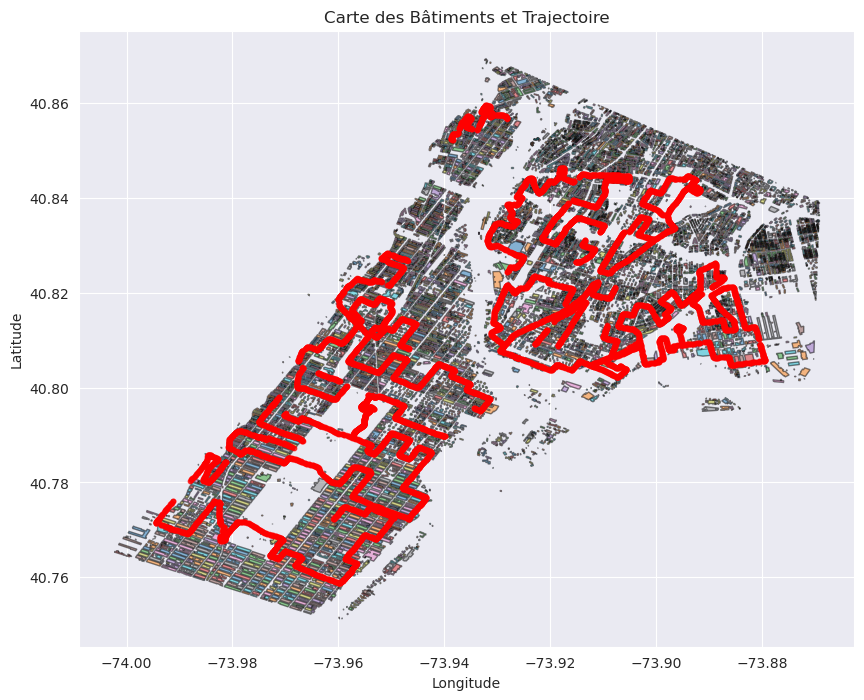

In [9]:
# Load the KML file of buildings
kml_file = "Data/Dataset/Building_Footprint.kml"
tree = ET.parse(kml_file)
root = tree.getroot()

# Extract building coordinates and create polygons
namespace = {'kml': 'http://www.opengis.net/kml/2.2'}
placemarks = root.findall('.//kml:Placemark', namespace)
polygons = []

for placemark in placemarks:
    coord_text = placemark.find('.//kml:coordinates', namespace).text.strip()
    coords = coord_text.split()
    polygon_coords = [(float(coord.split(',')[0]), float(coord.split(',')[1])) for coord in coords]
    polygons.append(Polygon(polygon_coords))

# Load trajectory points from CSV
csv_file = "Data/Dataset/Training_data_uhi_index_2025-02-18.csv"
df_trajectory = pd.read_csv(csv_file)
coordinates_to_check = df_trajectory[['Longitude', 'Latitude']].values

fig, ax = plt.subplots(figsize=(10, 8))

for poly in polygons:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.5, edgecolor='black', linewidth=1, label="Building")

ax.scatter(df_trajectory['Longitude'], df_trajectory['Latitude'], color='red', s=10, label="Trajectory", alpha=0.7)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Map of Buildings and Trajectory")
ax.legend()
plt.legend().set_visible(False)

plt.show()


### Étirement des polygones avec un buffer

Nous étirons tous les polygones avec un **buffer** afin de tout recouvrir (ce que je ne vais pas afficher ici pour le bonheur de nos yeux).


In [ ]:
kml_file = "Data/Dataset/Building_Footprint.kml"
tree = ET.parse(kml_file)
root = tree.getroot()


namespace = {'kml': 'http://www.opengis.net/kml/2.2'}

# Extract building coordinates and create polygons
placemarks = root.findall('.//kml:Placemark', namespace)
polygons = []

for placemark in placemarks:
    coord_text = placemark.find('.//kml:coordinates', namespace).text.strip()
    coords = coord_text.split()
    polygon_coords = [(float(coord.split(',')[0]), float(coord.split(',')[1])) for coord in coords]

    # Create a Shapely Polygon for each building and expand with a buffer
    polygon = Polygon(polygon_coords).buffer(0.0001)  # Adjust buffer value !
    polygons.append(polygon)


csv_file = ground_df
df_trajectory = pd.read_csv(csv_file)

building_associations = []

# Check if each trajectory point is inside a building
for lon, lat in df_trajectory[['Longitude', 'Latitude']].values:
    point = Point(lon, lat)

    # Find the first building that contains the point
    assigned_building = next((f"Building {i+1}" for i, polygon in enumerate(polygons) if polygon.contains(point)), "No Building")

    building_associations.append(assigned_building)


df_trajectory['Building'] = building_associations
df_result = df_trajectory[['Longitude', 'Latitude', 'Building']]
df_result.head()


### Conversion et ajout des données des bâtiments

Nous convertissons en **string** les différentes notations des bâtiments et les ajoutons à notre **jeu de données final**.


In [8]:
data_building = pd.read_csv(
    "Data/Building_Footprint.csv")
data_building['Building'] = data_building['Building'].astype('category').cat.codes
data_building = data_building["Building"]

# Final Data
final_data = pd.concat([data_building, final_data], axis=1)

### Suite possible avec les stations météos

Une suite possible aurait été d'utiliser les **stations météos** présentées dans le fichier Excel. Bien que je n'aie pas pris le temps de bien étudier cette option, une idée que j'aurais voulu mettre en place aurait été d'ajouter une **dépendance temporelle** entre les points. En effet, comme les données ont été récupérées à vélo, il est possible qu'il existe une certaine **cohérence temporelle** entre les indices et l'heure de la journée.


#  <u> Final Data

### Jeu de données final

Nous obtenons notre **jeu de données final** avec **697 colonnes**, ce qui est relativement élevé.


In [9]:
final_data = final_data.loc[:, ~final_data.columns.str.contains("Unnamed")]
print(final_data.shape)
final_data.head()

(11229, 697)


,Building,lwir11_Res1m_slice_1,lwir11_Res1m_slice_2,lwir11_Res1m_slice_3,lwir11_Res1m_slice_4,lwir11_Res1m_slice_5,lwir11_Res1m_slice_6,lwir11_Res1m_slice_7,lwir11_Res1m_slice_8,lwir11_Res1m_slice_9,...,B06_2022,B08_2022,B01_2023,B04_2023,B06_2023,B08_2023,B01_2024,B04_2024,B06_2024,B08_2024
0,323,2.371428,44.433582,44.443837,38.069229,38.089737,2.265470,43.708962,43.702126,37.378789,...,2482.0,2445.0,1892.5,2050.0,2473.0,2440.5,1856.0,2083.0,2630.0,2616.0
1,323,2.371428,44.433582,44.443837,38.069229,38.089737,2.265470,43.708962,43.702126,37.378789,...,2482.0,2445.0,1892.5,2050.0,2473.0,2440.5,1856.0,2083.0,2630.0,2616.0
2,323,2.265470,43.708962,43.702126,37.378789,37.389043,2.265470,43.708962,43.702126,37.378789,...,3479.0,2520.0,1892.5,1917.5,3403.0,2720.5,1856.0,1838.0,3714.0,2639.0
3,323,2.265470,43.708962,43.702126,37.378789,37.389043,2.265470,43.708962,43.702126,37.378789,...,3279.0,2520.0,1892.5,1905.5,3271.0,2720.5,1856.0,1817.0,3594.0,2639.0
4,323,2.265470,43.708962,43.702126,37.378789,37.389043,2.344084,43.346652,43.350070,36.835324,...,3108.0,2727.0,1892.5,1895.0,3106.0,2930.5,1856.0,1752.5,3404.0,2731.5


In [72]:
# final_data = final_data.drop(columns=["Latitude", "Longitude"], errors="ignore")
# print(final_data.shape)

#  <u> Model

### Choix de l'architecture du modèle

Nous passons maintenant au **choix de l'architecture du modèle**, ce qui va justifier, disons, l'approche **grossière** de la génération de données. En effet, étant donné que je ne pouvais pas consacrer trop de temps à ce projet, j'ai privilégié une approche standard de **deep learning** avec un réseau de neurones **dense** (fully connected) de **6 couches**.

Ce modèle a pu tourner dans un environnement **Linux** sur **PyTorch**, en utilisant un **GPU**, ce qui m'a permis d'obtenir des résultats intéressants assez rapidement.


In [74]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000 Laptop GPU'

### Présentation des résultats

Nous commençons par le **code d'optimisation des hyperparamètres**, car cela est plus agréable pour suivre l'évolution du modèle dans ce notebook. Cependant, il est logique de noter que ce n'est pas la **première** chose effectuée dans le processus.


## Recheche des meilleurs paramètres

### Choix des Inputs

Pour éviter de prendre trop de temps à l'entraînement, mais également pour limiter le travail en amont sur les données, j'ai choisi de donner à mon modèle dense les **données brutes**. Je me repose sur la **génération intrinsèque de données** (multi-résolution, etc.) pour introduire un lien entre les indices à prédire.


### Améliorations possibles

Bien entendu, les performances seraient **très certainement meilleures** si je regroupais les données de **Sentinel** et **Landsat** ensemble par années, peut-être sous forme d'**image 2D** pour appliquer des **Conv2D**, ou encore mieux, en les traitant avec des modèles **Seq2Seq** utilisant des **RNN** (peut-être un **LSTM bidirectionnel** ou, pour s'affranchir des séquences, l'utilisation de **Transformers**).

Cependant, selon moi, il n'était pas très pertinent de sortir "l'artillerie lourde" pour ce type de problème, où le gros de la performance se joue surtout sur la **sélection des données**. Dans le meilleur des cas, une simple **classification** pourrait suffire, vu le nombre relativement faible de valeurs uniques de l'indice.


### Normalisation des données et division en train/test

Nous normalisons nos données et les divisons en **train** et **test**. Même si les données de y sont déjà **plus ou moins normalisées** depuis le départ, nous utilisons **StandardScaler**. Cela permet d'éviter tout type de difficulté potentielle, car **StandardScaler** est un outil classiquement utilisé pour ce type de tâche.


In [44]:
# Load the data
X = final_data.values
y = ground_df['UHI Index'].values

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0, random_state=123)

# Normalize the target values
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Normalize the features
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Utilisation d'Optuna pour l'optimisation des hyperparamètres

J'ai utilisé **Optuna** pour trouver le meilleur ensemble de paramètres. Il s'agit d'une bibliothèque d'optimisation d'hyperparamètres qui utilise une approche efficace de recherche bayésienne et d'autres techniques avancées pour automatiser l'exploration des espaces de paramètres. Je l'ai utilisée pour affiner mon modèle en trouvant l'ensemble de paramètres optimal après avoir atteint un bon niveau de performance

En pratique, cela m'a permis d'obtenir un léger **amélioration des performances**, de l'ordre de **1%**, ce qui reste non négligeable.


In [ ]:
# Optimization function with Optuna
def objective(trial):
    hidden1 = trial.suggest_int("hidden1", 128, 512)
    hidden2 = trial.suggest_int("hidden2", 128, 512)
    hidden3 = trial.suggest_int("hidden3", 64, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    class MLPRegressor(nn.Module):
        def __init__(self):
            super(MLPRegressor, self).__init__()
            # Fully connected layers (Dense layers)
            self.fc1 = nn.Linear(X_train.shape[1], hidden1)
            self.fc2 = nn.Linear(hidden1,hidden2)
            self.fc3 = nn.Linear(hidden2, hidden3)
            self.fc4 = nn.Linear(hidden3, 64)
            self.fc5 = nn.Linear(64, 32)
            self.fc6 = nn.Linear(32, 1)


            self.dropout = nn.Dropout(dropout_rate)


            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.relu(self.fc3(x))
            x = self.relu(self.fc4(x))
            x = self.relu(self.fc5(x))
            x = self.fc6(x)
            return x

    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()


    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred.extend(outputs.cpu().numpy())


    y_pred = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


    r2 = r2_score(y_test_orig, y_pred)
    return r2

# Running the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)


print("Best trial:")
best_trial = study.best_trial
print(f"R2 Score: {best_trial.value}")
print("Best hyperparameters:", best_trial.params)


## Application des meilleurs paramètres et prévention de l'overfitting

Une fois les meilleurs paramètres trouvés, nous les appliquons et veillons à ne pas **overfitter** en ajustant le **nombre d'épochs**.

Pour visualiser les résultats, nous commençons avec un **test split de 9.5%** (correspondant approximativement à la taille du test). Ensuite, pour la soumission, nous entraînons le modèle sur le plus grand nombre de données possible.


In [71]:
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        # Fully connected layers (Dense layers)
        self.fc1 = nn.Linear(X_train.shape[1], 283)
        self.fc2 = nn.Linear(283, 358)
        self.fc3 = nn.Linear(358, 243)
        self.fc4 = nn.Linear(243, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)


        self.dropout = nn.Dropout(0.2002394793062901)


        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00017065820948176298)

num_epochs = 20  # Set to 200 for submission

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Evaluation mode
model.eval()
y_true = []
y_pred = []


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        outputs = model(X_batch)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())


r2 = r2_score(y_true, y_pred)
print(f"Test R² Score: {r2:.4f}")


Epoch [1/20], Loss: 0.5573
Epoch [2/20], Loss: 0.2971
Epoch [3/20], Loss: 0.2332
Epoch [4/20], Loss: 0.1959
Epoch [5/20], Loss: 0.1663
Epoch [6/20], Loss: 0.1540


KeyboardInterrupt: 

#  <u> Soumission

### Application du modèle aux données de soumission

Le plus dur est fait ! Maintenant, si toutes les données de **soumission** ont été correctement générées, nous les chargeons et appliquons le modèle **entraîné** plus haut.


In [59]:

# Sentinel
data_geotiff_median = pd.read_csv("/Data/final_dataset_sub.csv")

# Landsat
data_landsat_res_1 = pd.read_csv("Data/final_dataset_landsat_lwir11_res_1m_sub.csv")
data_landsat_res_80 = pd.read_csv("Data/final_dataset_landsat_lwir11_res_80_sub.csv")
data_landsat_res_10 = pd.read_csv("Data/final_dataset_landsat_lwir11_res_10m_sub.csv")
data_landsat_res_30 = pd.read_csv("Data/final_dataset_landsat_lwir11_res_30m_sub.csv")
data_landsat_res_50 = pd.read_csv("Data/final_dataset_landsat_lwir11_res_50m_sub.csv")
data_landsat_sub = pd.read_csv("Data/data_landsat_sub.csv")


final_data_sub =pd.concat([data_landsat_res_1,data_landsat_res_10, data_landsat_res_30,data_landsat_res_50,data_landsat_res_80,data_landsat_sub,data_geotiff_median], axis=1)
final_data_sub= final_data_sub.loc[:, ~final_data_sub.columns.str.contains("Unnamed")]



# Buildings.kml
data_building_sub = pd.read_csv(
    "Data/Building_Footprint_sub.csv")
data_building_sub['Building'] = data_building_sub['Building'].astype('category').cat.codes
data_building_sub = data_building_sub["Building"]


final_data_sub = pd.concat([ data_building_sub, final_data_sub], axis=1)
final_data_sub = final_data_sub.loc[:, ~final_data_sub.columns.str.contains("Unnamed")]

print(final_data_sub.shape)
final_data_sub

(1040, 697)


,Building,lwir11_Res1m_slice_1,lwir11_Res1m_slice_2,lwir11_Res1m_slice_3,lwir11_Res1m_slice_4,lwir11_Res1m_slice_5,lwir11_Res1m_slice_6,lwir11_Res1m_slice_7,lwir11_Res1m_slice_8,lwir11_Res1m_slice_9,...,B06_2022,B08_2022,B01_2023,B04_2023,B06_2023,B08_2023,B01_2024,B04_2024,B06_2024,B08_2024
0,284,-124.150000,-124.150000,42.683556,35.013519,35.105806,-124.150000,-124.150000,42.683556,35.013519,...,3475.0,2559.0,1796.0,1540.0,3634.0,2653.0,1702.5,1494.0,3358.5,2611.0
1,284,-124.150000,-124.150000,42.526327,35.170748,35.263035,-124.150000,-124.150000,42.526327,35.170748,...,4406.0,2744.5,2127.0,1616.5,4298.0,2840.0,2100.0,1527.5,4358.0,2739.5
2,286,-124.150000,-124.150000,40.772883,34.340169,34.329915,-124.150000,-124.150000,40.772883,34.340169,...,2131.0,2101.5,1989.0,1819.5,2155.0,2195.5,1919.5,1797.0,2088.0,2136.0
3,285,-124.150000,-124.150000,41.726511,34.651209,34.692225,-124.150000,-124.150000,42.584434,35.611673,...,2269.0,3330.0,2111.5,2078.0,2280.0,3267.5,2068.5,1958.0,2127.0,3158.0
4,371,-124.150000,-124.150000,40.701105,33.871901,33.882155,-124.150000,-124.150000,40.701105,33.871901,...,3097.0,2964.0,2057.0,2002.0,3265.0,3044.0,2007.0,1851.0,3422.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,23,2.884131,47.212433,47.301301,39.891034,39.945722,2.884131,47.212433,47.301301,39.891034,...,2474.0,3363.5,2391.0,2208.0,2438.0,3203.0,2356.0,2244.0,2422.0,3203.5
1036,233,16.638244,42.628868,42.652794,35.799664,35.823590,16.638244,42.628868,42.652794,35.799664,...,3944.0,2963.0,2129.5,1882.0,3664.0,2955.5,2087.5,1790.5,3848.0,2807.5
1037,349,30.409446,45.985364,46.019544,38.629784,38.660547,30.409446,45.985364,46.019544,38.629784,...,3278.0,2956.0,1987.5,2390.0,3268.0,3015.0,2000.0,2380.0,3376.0,2963.5
1038,187,2.812353,47.144072,47.164580,39.552650,39.573158,2.812353,47.144072,47.164580,39.552650,...,3302.0,3879.5,2646.5,2618.0,3496.0,3744.5,2549.0,2914.0,3340.5,3852.5


### Dé-normalisation et ajout des coordonnées

On n'oublie pas de **dé-normaliser** les données et d'ajouter les **latitudes** et **longitudes** du **submission_template** pour correspondre aux règles de soumission.


In [69]:
X_sub = final_data_sub.values
X_sub_normalized = scaler_x.transform(X_sub)
X_sub_tensor = torch.tensor(X_sub_normalized, dtype=torch.float32)

model.eval()
y_sub_pred = []

with torch.no_grad():
    outputs = model(X_sub_tensor.to(device))
    y_sub_pred.extend(outputs.cpu().numpy())


y_sub_pred = np.array(y_sub_pred).flatten()
y_pred_denorm = scaler_y.inverse_transform(y_sub_pred.reshape(-1, 1)).flatten()

submission_df = pd.DataFrame({'Longitude': submission_template['Longitude'].values, 'Latitude':submission_template['Latitude'].values, 'UHI Index':y_pred_denorm})
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.962733
1,-73.971928,40.788875,0.963454
2,-73.967080,40.789080,0.961170
3,-73.972550,40.789082,0.961290
4,-73.969697,40.787953,0.959908


In [ ]:
# submission_df.to_csv("submission_df.csv", index=False)